# IMPORT LIBRARY DAN SETUP

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# PEMBACAAN DAN PEMBERSIHAN DATA

In [11]:
# Baca data dari Excel
df = pd.read_excel('IPH Kota Batu.xlsx')

# Bersihkan data dengan forward fill untuk kolom Bulan dan hapus missing values
df_clean = df.copy()
df_clean['Bulan'] = df_clean['Bulan'].fillna(method='ffill')
df_clean = df_clean.dropna(subset=[' Indikator Perubahan Harga (%)'])

print(f"Data berhasil dibersihkan: {len(df_clean)} observasi")
print("Kolom yang tersedia:", df_clean.columns.tolist())

Data berhasil dibersihkan: 118 observasi
Kolom yang tersedia: ['Bulan', 'Minggu ke-', 'Kab/Kota', ' Indikator Perubahan Harga (%)', 'Komoditas Andil Perubahan Harga ', 'Komoditas Fluktuasi Harga Tertinggi', 'Fluktuasi Harga']


# FUNGSI EKSTRAKSI WAKTU

In [12]:
def ekstrak_tahun(bulan_str):
    """Ekstrak tahun dari string bulan"""
    if "'24" in str(bulan_str):
        return 2024
    elif "'25" in str(bulan_str):
        return 2025
    else:
        return 2023

def ekstrak_bulan(bulan_str):
    """Ekstrak nomor bulan dari nama bulan"""
    peta_bulan = {
        'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
        'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
        'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
    }
    bulan_bersih = str(bulan_str).split("'")[0]  # Hapus '24 atau '25
    for nama_bulan, nomor_bulan in peta_bulan.items():
        if nama_bulan in bulan_bersih:
            return nomor_bulan
    return 1

def ekstrak_minggu(minggu_str):
    """Ekstrak angka minggu dari format M1, M2, M3, M4, M5"""
    if pd.isna(minggu_str):
        return 1
    minggu_num = str(minggu_str).replace('M', '')
    try:
        return int(minggu_num)
    except:
        return 1

def buat_tanggal(tahun, bulan, minggu):
    """Buat tanggal berdasarkan tahun, bulan, dan minggu ke-"""
    try:
        # Tanggal awal bulan
        tanggal_awal = datetime(tahun, bulan, 1)
        # Cari hari Senin pertama di bulan tersebut
        hari_senin_pertama = tanggal_awal
        while hari_senin_pertama.weekday() != 0:  # 0 = Senin
            hari_senin_pertama += timedelta(days=1)
        
        # Tambahkan minggu sesuai dengan M1, M2, dst
        tanggal_final = hari_senin_pertama + timedelta(weeks=minggu-1)
        return tanggal_final
    except:
        return datetime(tahun, bulan, 1)

Fungsi: Membuat fungsi-fungsi untuk mengekstrak informasi waktu dari format data yang ada (tahun, bulan, minggu) dan mengkonversinya menjadi tanggal yang sesuai.

# PEMBUATAN KOLOM WAKTU DAN URUTAN

In [13]:
print("\nLANGKAH 4: MEMBUAT URUTAN WAKTU")
print("="*40)

# Buat kolom waktu menggunakan fungsi yang sudah didefinisikan
df_clean['Tahun'] = df_clean['Bulan'].apply(ekstrak_tahun)
df_clean['Bulan_Angka'] = df_clean['Bulan'].apply(ekstrak_bulan)
df_clean['Minggu_Angka'] = df_clean['Minggu ke-'].apply(ekstrak_minggu)

# Buat kolom tanggal
df_clean['Tanggal'] = df_clean.apply(lambda row: buat_tanggal(row['Tahun'], row['Bulan_Angka'], row['Minggu_Angka']), axis=1)

# Urutkan data berdasarkan tanggal dan buat periode berurutan
df_clean = df_clean.sort_values('Tanggal').reset_index(drop=True)
df_clean['Periode'] = range(1, len(df_clean) + 1)

print(f"Periode data: {df_clean['Tanggal'].min()} sampai {df_clean['Tanggal'].max()}")
print(f"Total periode: {len(df_clean)} minggu")


LANGKAH 4: MEMBUAT URUTAN WAKTU
Periode data: 2023-01-02 00:00:00 sampai 2025-06-23 00:00:00
Total periode: 118 minggu


Fungsi: Menerapkan fungsi ekstraksi waktu untuk membuat kolom tahun, bulan, minggu, tanggal, dan periode yang berurutan untuk keperluan time series.

# PERSIAPAN DATA UNTUK MODELING

In [14]:
print("\nLANGKAH 5: PERSIAPAN DATA UNTUK MODELING")
print("="*40)

# Pilih kolom yang diperlukan untuk modeling saja
modeling_data = df_clean[['Periode', 'Tanggal', 'Bulan', 'Minggu ke-', 
                         ' Indikator Perubahan Harga (%)', 'Tahun', 'Bulan_Angka', 'Minggu_Angka']].copy()

# Rename kolom untuk kemudahan
modeling_data.columns = ['Periode', 'Tanggal', 'Bulan', 'Minggu', 'Indikator_Harga', 'Tahun', 'Bulan_Numerik', 'Minggu_Dalam_Bulan']

# Konversi ke numerik
modeling_data['Indikator_Harga'] = pd.to_numeric(modeling_data['Indikator_Harga'], errors='coerce')

print("Dataset untuk modeling siap:")
print(modeling_data.head())
print(f"Shape data: {modeling_data.shape}")


LANGKAH 5: PERSIAPAN DATA UNTUK MODELING
Dataset untuk modeling siap:
   Periode    Tanggal     Bulan Minggu  Indikator_Harga  Tahun  Bulan_Numerik  \
0        1 2023-01-02   Januari     M1            -1.34   2023              1   
1        2 2023-01-09   Januari     M2             0.93   2023              1   
2        3 2023-02-13  Februari     M2             1.36   2023              2   
3        4 2023-02-20  Februari     M3             1.82   2023              2   
4        5 2023-02-27  Februari     M4             2.18   2023              2   

   Minggu_Dalam_Bulan  
0                   1  
1                   2  
2                   2  
3                   3  
4                   4  
Shape data: (118, 8)


Fungsi: Menyiapkan dataset khusus untuk modeling dengan hanya mengambil kolom yang diperlukan dan melakukan konversi tipe data yang sesuai.

# PEMBUATAN FITUR LAG DAN MOVING AVERAGE

In [15]:
print("\nLANGKAH 6: MENAMBAH FITUR LAG DAN MOVING AVERAGE")
print("="*40)

# Tambah lag features (nilai periode sebelumnya)
for lag in [1, 2, 3, 4]:
    modeling_data[f'Lag_{lag}'] = modeling_data['Indikator_Harga'].shift(lag)

# Tambah moving averages (rata-rata bergerak)
modeling_data['MA_3'] = modeling_data['Indikator_Harga'].rolling(window=3).mean()
modeling_data['MA_7'] = modeling_data['Indikator_Harga'].rolling(window=7).mean()

# Hapus missing values yang terbentuk dari lag dan moving average
modeling_data_clean = modeling_data.dropna()

print(f"Data dengan fitur lag: {len(modeling_data_clean)} observasi")
print("Fitur yang tersedia untuk modeling:", [col for col in modeling_data_clean.columns if col not in ['Periode', 'Tanggal', 'Bulan', 'Minggu']])


LANGKAH 6: MENAMBAH FITUR LAG DAN MOVING AVERAGE
Data dengan fitur lag: 112 observasi
Fitur yang tersedia untuk modeling: ['Indikator_Harga', 'Tahun', 'Bulan_Numerik', 'Minggu_Dalam_Bulan', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'MA_3', 'MA_7']


Fungsi: Membuat fitur lag (nilai periode sebelumnya) dan moving average yang penting untuk prediksi time series, kemudian membersihkan data dari missing values.

# VISUALISASI TIME SERIES


LANGKAH 7: VISUALISASI TIME SERIES


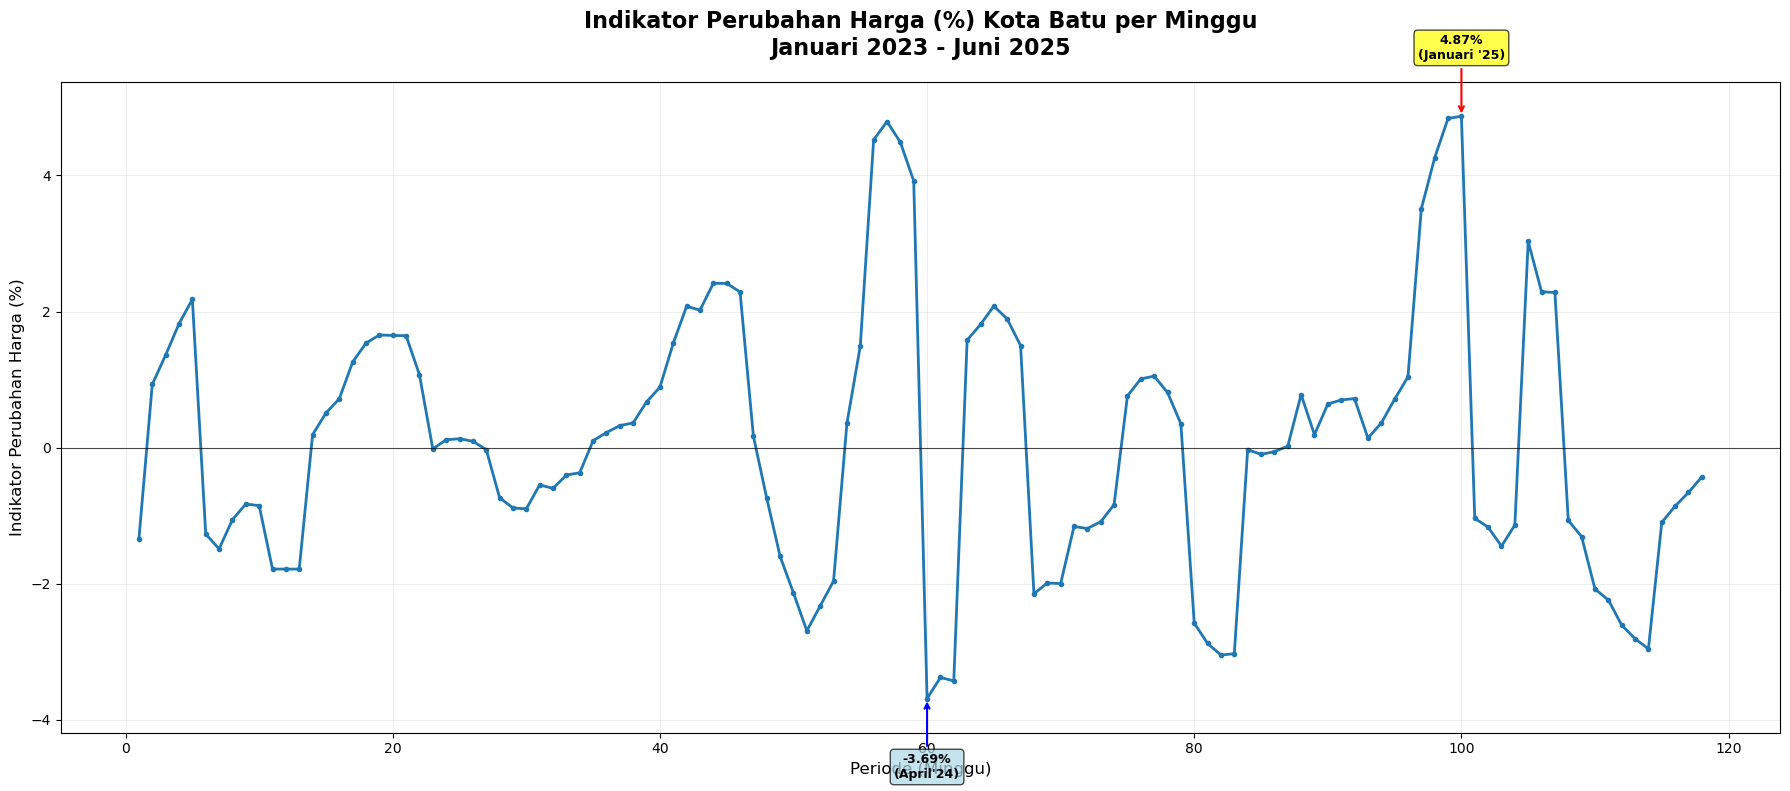

Visualisasi time series berhasil dibuat!


In [16]:
print("\nLANGKAH 7: VISUALISASI TIME SERIES")
print("="*40)

# Setup plotting
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

# Buat plot time series
fig, ax = plt.subplots(figsize=(18, 8))

# Plot garis utama
ax.plot(modeling_data['Periode'], modeling_data['Indikator_Harga'], 
        color='#1f77b4', linewidth=2, marker='o', markersize=3)

# Tambahkan grid dan formatting
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Set labels dan title
ax.set_title('Indikator Perubahan Harga (%) Kota Batu per Minggu\nJanuari 2023 - Juni 2025', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Periode (Minggu)', fontsize=12)
ax.set_ylabel('Indikator Perubahan Harga (%)', fontsize=12)

# Set range dan garis horizontal di y=0
y_min = modeling_data['Indikator_Harga'].min() - 0.5
y_max = modeling_data['Indikator_Harga'].max() + 0.5
ax.set_ylim(y_min, y_max)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

# Annotate titik maksimum dan minimum
max_idx = modeling_data['Indikator_Harga'].idxmax()
min_idx = modeling_data['Indikator_Harga'].idxmin()

max_val = modeling_data.loc[max_idx, 'Indikator_Harga']
min_val = modeling_data.loc[min_idx, 'Indikator_Harga']
max_periode = modeling_data.loc[max_idx, 'Periode']
min_periode = modeling_data.loc[min_idx, 'Periode']
max_bulan = modeling_data.loc[max_idx, 'Bulan']
min_bulan = modeling_data.loc[min_idx, 'Bulan']

ax.annotate(f'{max_val:.2f}%\n({max_bulan})', 
            xy=(max_periode, max_val), 
            xytext=(max_periode, max_val + 0.8),
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

ax.annotate(f'{min_val:.2f}%\n({min_bulan})', 
            xy=(min_periode, min_val), 
            xytext=(min_periode, min_val - 0.8),
            ha='center', va='top', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))

plt.tight_layout()
plt.show()

print("Visualisasi time series berhasil dibuat!")

Fungsi: Membuat visualisasi time series yang informatif dengan menampilkan tren data, titik maksimum dan minimum, serta formatting yang baik untuk analisis visual.

# SPLIT DATA TRAINING DAN TESTING

In [17]:
# SPLIT DATA TRAINING DAN TESTING
print("\nLANGKAH 8: SPLIT DATA UNTUK TRAINING DAN TESTING")
print("="*40)

# Import library untuk membuat folder
import os

# Buat folder dataset jika belum ada
dataset_folder = 'dataset'
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    print(f"Folder '{dataset_folder}' berhasil dibuat")
else:
    print(f"Folder '{dataset_folder}' sudah ada")

# Split data 80-20 untuk training-testing
split_point = int(0.8 * len(modeling_data_clean))

train_data = modeling_data_clean.iloc[:split_point].copy()
test_data = modeling_data_clean.iloc[split_point:].copy()

print(f"Training data: {len(train_data)} observasi")
print(f"Testing data: {len(test_data)} observasi")
print(f"Periode training: {train_data['Tanggal'].min()} sampai {train_data['Tanggal'].max()}")
print(f"Periode testing: {test_data['Tanggal'].min()} sampai {test_data['Tanggal'].max()}")

# Simpan data untuk modeling ke dalam folder dataset
train_file = os.path.join(dataset_folder, 'data_iph_training.csv')
test_file = os.path.join(dataset_folder, 'data_iph_testing.csv')
modeling_data_clean.to_csv('data_iph_modeling.csv', index=False)

train_data.to_csv(train_file, index=False)
test_data.to_csv(test_file, index=False)


LANGKAH 8: SPLIT DATA UNTUK TRAINING DAN TESTING
Folder 'dataset' berhasil dibuat
Training data: 89 observasi
Testing data: 23 observasi
Periode training: 2023-03-13 00:00:00 sampai 2024-12-16 00:00:00
Periode testing: 2024-12-23 00:00:00 sampai 2025-06-23 00:00:00


Fungsi: Membagi data menjadi training set (80%) dan testing set (20%) untuk evaluasi model, serta menyimpan dataset yang siap untuk modeling.

# SUMMARY STATISTIK DAN INFORMASI FINAL

In [18]:
# SUMMARY STATISTIK DAN INFORMASI FINAL
print("\nLANGKAH 9: SUMMARY STATISTIK")
print("="*40)

# Buat summary statistik
summary_stats = {
    'Total_Observasi': len(modeling_data_clean),
    'Training_Data': len(train_data),
    'Testing_Data': len(test_data),
    'Periode_Awal': modeling_data_clean['Tanggal'].min().strftime('%Y-%m-%d'),
    'Periode_Akhir': modeling_data_clean['Tanggal'].max().strftime('%Y-%m-%d'),
    'Nilai_Minimum': modeling_data_clean['Indikator_Harga'].min(),
    'Nilai_Maksimum': modeling_data_clean['Indikator_Harga'].max(),
    'Rata_rata': modeling_data_clean['Indikator_Harga'].mean(),
    'Standar_Deviasi': modeling_data_clean['Indikator_Harga'].std()
}

print("SUMMARY STATISTIK IPH KOTA BATU:")
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Tampilkan fitur untuk modeling
features_for_modeling = [col for col in modeling_data_clean.columns 
                        if col.startswith('Lag_') or col.startswith('MA_') or col in ['Bulan_Numerik', 'Minggu_Dalam_Bulan']]

print(f"\nFITUR UNTUK MODELING:")
print("Target variable: 'Indikator_Harga'")
print("Features available:", features_for_modeling)

print(f"\nContoh data terakhir:")
print(modeling_data_clean[['Periode', 'Tanggal', 'Bulan', 'Indikator_Harga', 'Lag_1', 'MA_3']].tail())

print(f"\n{'='*60}")
print("DATA SIAP UNTUK MODELING!")
print("File yang dihasilkan di folder 'dataset':")
print("1. dataset/data_iph_training.csv - Data training (80%)")
print("2. dataset/data_iph_testing.csv - Data testing (20%)")  
print("3. dataset/data_iph_modeling.csv - Dataset lengkap untuk modeling")
print(f"{'='*60}")


LANGKAH 9: SUMMARY STATISTIK
SUMMARY STATISTIK IPH KOTA BATU:
Total_Observasi: 112
Training_Data: 89
Testing_Data: 23
Periode_Awal: 2023-03-13
Periode_Akhir: 2025-06-23
Nilai_Minimum: -3.6900
Nilai_Maksimum: 4.8700
Rata_rata: 0.0688
Standar_Deviasi: 1.9399

FITUR UNTUK MODELING:
Target variable: 'Indikator_Harga'
Features available: ['Bulan_Numerik', 'Minggu_Dalam_Bulan', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'MA_3', 'MA_7']

Contoh data terakhir:
     Periode    Tanggal    Bulan  Indikator_Harga  Lag_1      MA_3
113      114 2025-06-02   Mei'25            -2.96  -2.81 -2.793333
114      115 2025-06-02  Juni'25            -1.10  -2.96 -2.290000
115      116 2025-06-09  Juni'25            -0.86  -1.10 -1.640000
116      117 2025-06-16  Juni'25            -0.66  -0.86 -0.873333
117      118 2025-06-23  Juni'25            -0.43  -0.66 -0.650000

DATA SIAP UNTUK MODELING!
File yang dihasilkan di folder 'dataset':
1. dataset/data_iph_training.csv - Data training (80%)
2. dataset/data_iph_tes

Fungsi: Memberikan ringkasan statistik lengkap, menampilkan fitur yang tersedia untuk modeling, dan memberikan informasi final tentang file yang dihasilkan untuk tahap modeling selanjutnya.